# Q5: Analysis (20 points)
By now you should know how to train networks from scratch or using from pre-trained models. You should also understand the relative performance in either scenarios. Needless to say, the performance of these models is stronger than previous non-deep architectures used until 2012. However, final performance is not the only metric we care about. It is important to get some intuition of what these models are really learning. Lets try some standard techniques.


**FEEL FREE TO WRITE UTIL CODE IN ANOTHER FILE AND IMPORT IN THIS NOTEBOOK FOR EASE OF READABILITY**

## 5.1 Nearest Neighbors (7 pts)
Pick 3 images from PASCAL test set from different classes, and compute 4 nearest neighbors over the entire test set for each of them. You should compare the following feature representations to find the nearest neighbors:
1. The features before the final fc layer from the ResNet (finetuned from ImageNet). It is the features right before the final class label output.
2. pool5 features from the CaffeNet (trained from scratch)

You may use the [this nearest neighbor function](https://scikit-learn.org/stable/modules/neighbors.html).
Plot the raw images of the ones you picked and their nearest neighbors.

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import models
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
%matplotlib inline

import trainer
from utils import ARGS
from simple_cnn import SimpleCNN
from voc_dataset import VOCDataset

# Load all the test images. Pick 3 indices.
dataset = VOCDataset(split='test', size=224, return_idx=True)
loader = DataLoader(dataset, batch_size=256, num_workers=4)

# Calculate the features for all the test images.
class CaffeNet(nn.Module):
    def __init__(self, num_classes=20, inp_size=224, c_dim=3):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 96, 11, stride=4, padding="valid")
        self.pool1 = nn.MaxPool2d(3, 2)
        self.conv2 = nn.Conv2d(96, 256, 5, stride=1, padding="same")
        self.pool2 = nn.MaxPool2d(3, 2)
        self.conv3 = nn.Conv2d(256, 384, 3, stride=1, padding="same")
        self.conv4 = nn.Conv2d(384, 384, 3, stride=1, padding="same")
        self.conv5 = nn.Conv2d(384, 256, 3, stride=1, padding="same")
        self.pool5 = nn.MaxPool2d(3, 2)
        
        self.fc6 = nn.Linear(6400, 4096)
        self.dropout6 = nn.Dropout(0.5)
        self.fc7 = nn.Linear(4096, 4096)
        self.dropout7 = nn.Dropout(0.5)
        
        self.fc8 = nn.Linear(4096, 20)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.forward_features(x)
        x = F.relu(x)
        x = self.dropout7(x)
        x = self.fc8(x)
        x = self.sigmoid(x)
        return x
    
    def forward_features(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = self.conv5(x)
        x = F.relu(x)
        x = self.pool5(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc6(x)
        x = F.relu(x)
        x = self.dropout6(x)
        x = self.fc7(x)
        return x
    
class PretrainedResNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.pretrained = models.resnet18(pretrained=True)
        self.pretrained.fc = nn.Linear(512, 20)
        self.sig = nn.Sigmoid()
    
    def forward(self, x):
        logits = self.pretrained(x)
        return self.sig(logits)
    
    def forward_features(self, x):
        batch_size = x.shape[0]
        x = self.pretrained.conv1(x)
        x = self.pretrained.bn1(x)
        x = self.pretrained.relu(x)
        x = self.pretrained.maxpool(x)
        x = self.pretrained.layer1(x)
        x = self.pretrained.layer2(x)
        x = self.pretrained.layer3(x)
        x = self.pretrained.layer4(x)
        x = self.pretrained.avgpool(x)
        return x.view(batch_size, -1)


caffenet = CaffeNet()
caffenet.load_state_dict(torch.load("models/checkpoint-caffenet_scratch-epoch50.pth"))
caffenet.eval()
resnet = PretrainedResNet()
resnet.load_state_dict(torch.load("models/checkpoint-resnet_finetuned-epoch10.pth"))
resnet.eval()

selected_indices = np.random.choice(len(dataset), size=3)
images = []
targets = []
caffenet_features = []
resnet_features = []
indices = []

# Fine the nearest neighbors for the 3 images you picked.
with torch.no_grad():
    for data, target, wgt, ind in loader:
        size = data.shape[0]
        caffenet_features.append(caffenet.forward_features(data))
        resnet_features.append(resnet.forward_features(data))
        targets.append(target)
        indices.append(ind)
    
print("Done with features")

caffenet_features = torch.cat(caffenet_features, dim=0).cpu().numpy()
resnet_features = torch.cat(resnet_features, dim=0).cpu().numpy()
targets = torch.cat(targets, dim=0)
indices = torch.cat(indices, dim=0)

In [9]:
# Plot the images and their neighbors.
caffenet_neighbors = NearestNeighbors(n_neighbors=5, algorithm='ball_tree', n_jobs=8).fit(caffenet_features)
_, caffenet_indices = caffenet_neighbors.kneighbors(caffenet_features)
caffenet_k_indices = caffenet_indices[selected_indices]
resnet_neighbors = NearestNeighbors(n_neighbors=5, algorithm='ball_tree', n_jobs=8).fit(resnet_features)
_, resnet_indices = resnet_neighbors.kneighbors(resnet_features)
resnet_k_indices = resnet_indices[selected_indices]

print(caffenet_k_indices)
print(resnet_k_indices)

[[2956 3117 4714 3798 2979]
 [ 532 2155 4315 3774 1458]
 [2162  101 1434 4903 2020]]
[[2956 2890 1059 2979 1557]
 [ 532 3931  634 4678   20]
 [2162 1697  591 2084  300]]


Selected Image: 1


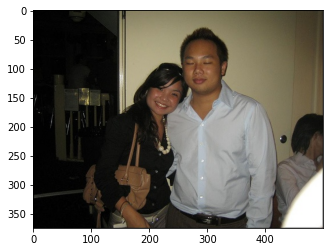

CaffeNet Nearest Neighbors:


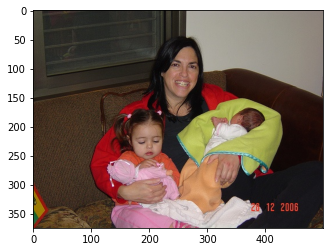

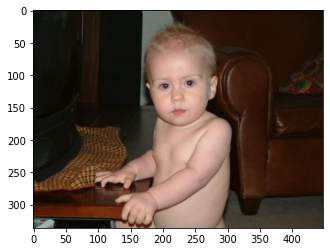

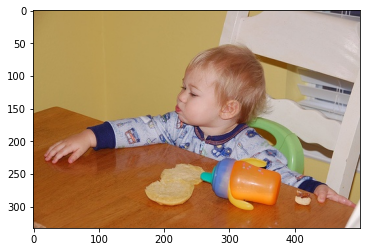

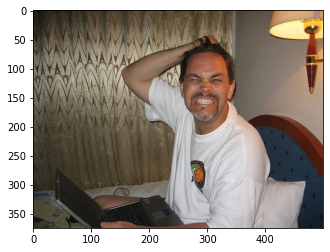

ResNet Nearest Neighbors:


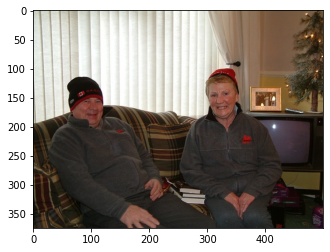

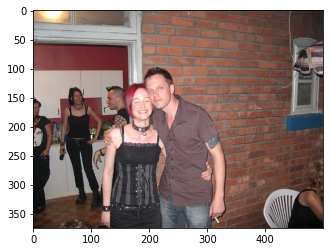

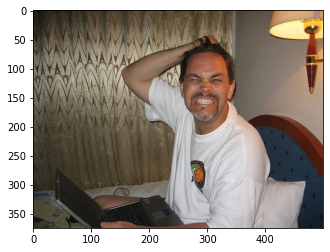

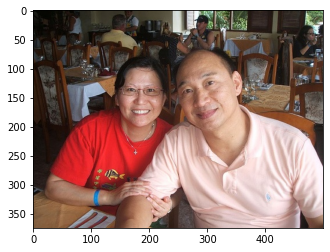

Selected Image: 2


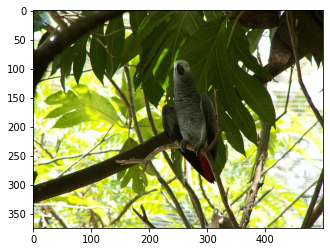

CaffeNet Nearest Neighbors:


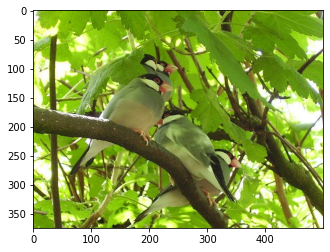

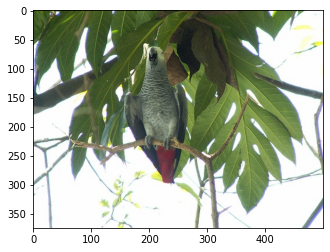

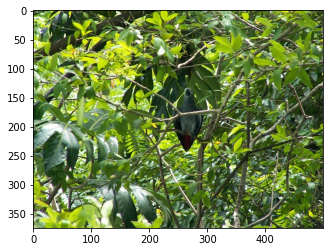

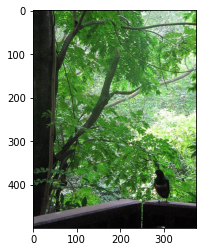

ResNet Nearest Neighbors:


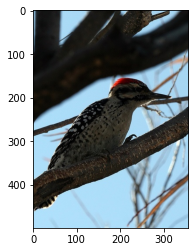

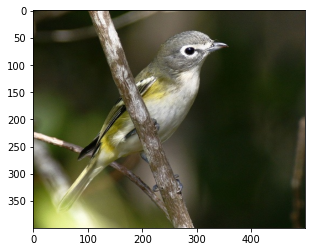

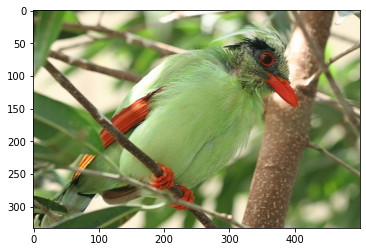

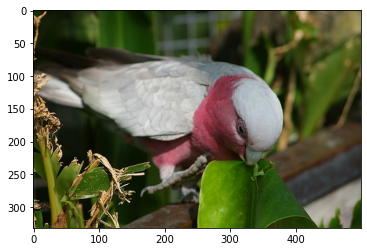

Selected Image: 3


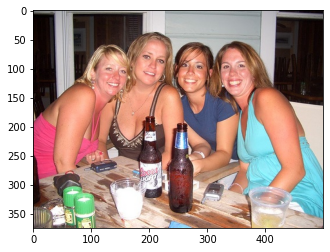

CaffeNet Nearest Neighbors:


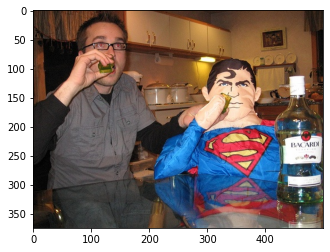

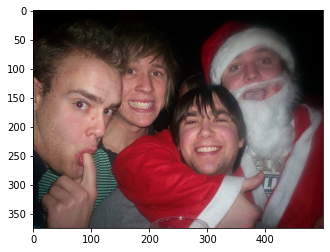

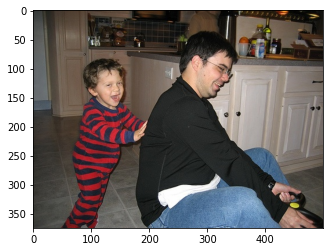

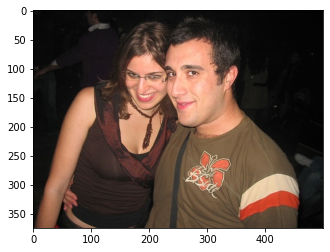

ResNet Nearest Neighbors:


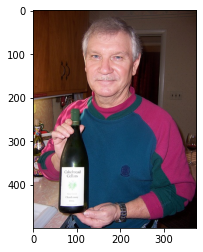

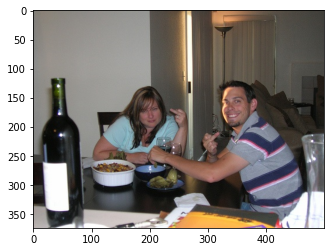

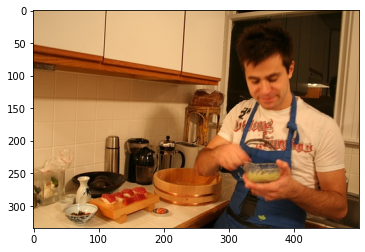

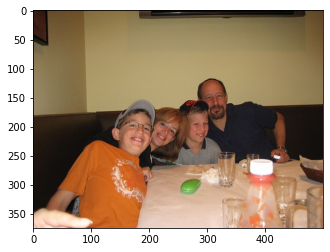

In [13]:
indices = indices.flatten()
for i in range(3):
    print("Selected Image: {}".format(i + 1))
    plt.imshow(dataset.get_image(indices[selected_indices[i]]))
    plt.show()
    print("CaffeNet Nearest Neighbors:")
    for j in range(1, 5):
        plt.imshow(dataset.get_image(indices[caffenet_k_indices[i, j]]))
        plt.show()
    print("ResNet Nearest Neighbors:")
    for j in range(1, 5):
        plt.imshow(dataset.get_image(indices[resnet_k_indices[i, j]]))
        plt.show()
        

## 5.2 t-SNE visualization of intermediate features (7pts)
We can also visualize how the feature representations specialize for different classes. Take 1000 random images from the test set of PASCAL, and extract caffenet (scratch) fc7 features from those images. Compute a 2D [t-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) projection of the features, and plot them with each feature color coded by the GT class of the corresponding image. If multiple objects are active in that image, compute the color as the ”mean” color of the different classes active in that image. Legend the graph with the colors for each object class.

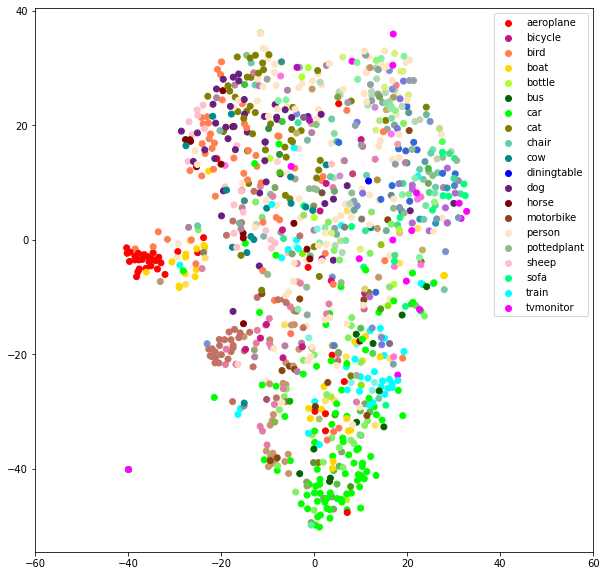

In [28]:
from sklearn.manifold import TSNE

features = caffenet_features[:1000]
targets = targets[:1000]

embedding = TSNE(n_components=2, init='random').fit_transform(features)
class_colors = np.array([[255, 0, 0], [199, 21, 133], [255, 127, 80], [255, 215, 0], [173, 255, 47], [0, 100, 0], [0, 255, 0], [128, 128, 0], [102, 205, 170], [0, 139, 139], [0, 0, 255], [104, 30, 126], [128, 0, 0], [139, 69, 19], [255, 228, 196], [143, 188, 143], [255, 192, 203], [0, 255, 127], [0, 255, 255], [255, 0, 255]]) / 255.0
embedding_colors = []
for target in targets.cpu().numpy():
    nonzero = np.nonzero(target)[0]
    c = np.zeros((3,))
    for i in nonzero:
        c += class_colors[i]
    c /= np.sum(target)
    embedding_colors.append(c)
fig = plt.figure(figsize=(10, 10))
plt.scatter(embedding[:, 0], embedding[:, 1], c=embedding_colors)
for i in range(20):
    plt.scatter([-40], [-40], color=class_colors[i], label=dataset.CLASS_NAMES[i])
plt.xlim(-60, 60)
plt.legend()
plt.show()

## 5.3 Are some classes harder? (6pts)
Show the per-class performance of your caffenet (scratch) and ResNet (finetuned) models. This is an open-ended question and you may use any performance metric that makes sense. Try to explain, by observing examples from the dataset, why some classes are harder or easier than the others (consider the easiest and hardest class). Do some classes see large gains due to pre-training? Can you explain why that might happen?

Looking at the average precision across both networks, the person class has the highest AP for both. I believe that this is a function of the large class imbalance that exists in the VOC dataset. From the VOC paper, we can see that the person class constitutes more than 40% of the total detections in the trainval set.

I also looked at the bottle class in particular because it has the lowests AP for the CaffeNet. I saw that there was a good amount of intraclass variation within the bottle colors, labels, shapes. In addition, some bottles are some level of translucent which could cause further ambiguity in the features associated with the class. Even on the pretrained ResNet, the bottle class has the lowest AP, leading me to believe it is just a difficult object to classify correctly.

On the other hand, something like cow which is fairly easy to identify, but has a low AP on CaffeNet due to a small number of training samples, sees a large increase do to pretraining. Its AP on CaffeNet is significantly lower than Dining Table, TV Monitor, and Chair, but with pretraining it gets a higher AP.

In [7]:
from utils import eval_dataset_map

dataset = VOCDataset(split='test', size=224, return_idx=False)
loader = DataLoader(dataset, batch_size=256, num_workers=4)

device = torch.device("cuda:0")
caffenet.to(device)
resnet.to(device)

AP, mAP = eval_dataset_map(caffenet, device, loader)
print("CaffeNet mAP: {}".format(mAP))
for i, cl in enumerate(dataset.CLASS_NAMES):
    print("{} AP: {}".format(cl, AP[i]))
    
print("\n")

AP, mAP = eval_dataset_map(resnet, device, loader)
print("ResNet: {}".format(mAP))
for i, cl in enumerate(dataset.CLASS_NAMES):
    print("{} AP: {}".format(cl, AP[i]))

CaffeNet mAP: 0.41472539350365956
aeroplane AP: 0.6065504026749763
bicycle AP: 0.41801974981382123
bird AP: 0.3611896311683254
boat AP: 0.4849899090288321
bottle AP: 0.15331735760720447
bus AP: 0.37967164871846043
car AP: 0.6574895040158589
cat AP: 0.3818925820701358
chair AP: 0.3531412948386369
cow AP: 0.21356614445691155
diningtable AP: 0.2978809862687926
dog AP: 0.30000526286964446
horse AP: 0.6713839272249968
motorbike AP: 0.5460125968488998
person AP: 0.7818792689454563
pottedplant AP: 0.19232334763930692
sheep AP: 0.27520590825510505
sofa AP: 0.30421640841885306
train AP: 0.552619860721478
tvmonitor AP: 0.36315207848749625


ResNet: 0.8543920568846026
aeroplane AP: 0.9585709949751373
bicycle AP: 0.9346132642884324
bird AP: 0.9199991863050734
boat AP: 0.9178930703185753
bottle AP: 0.5686803123738275
bus AP: 0.8556680428725884
car AP: 0.9386909914376396
cat AP: 0.9135866189157451
chair AP: 0.7112527588037817
cow AP: 0.8186023131387906
diningtable AP: 0.7920118251635698
dog AP: 0.90

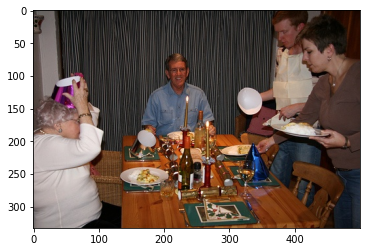

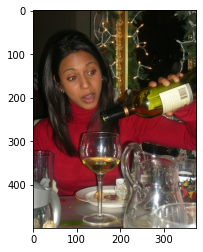

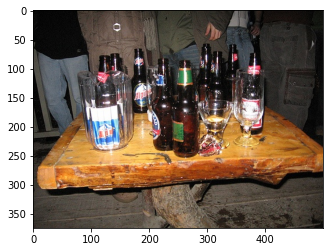

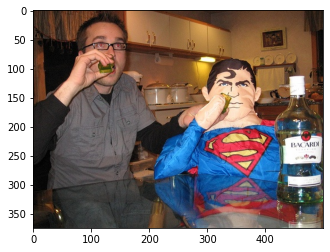

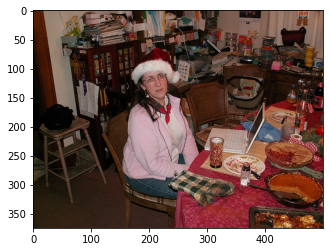

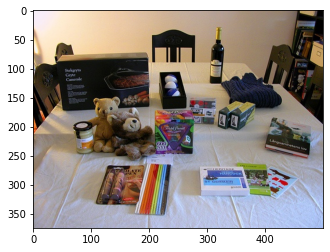

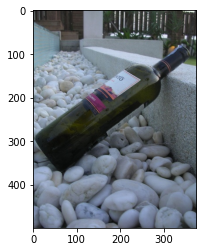

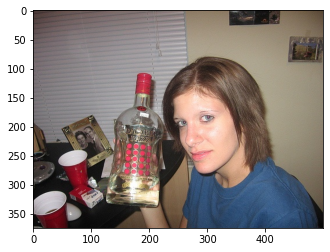

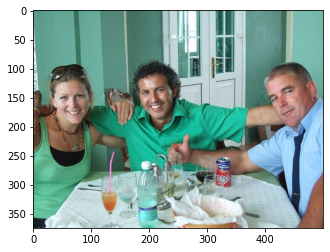

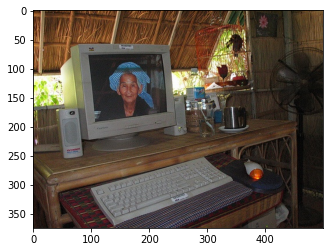

In [5]:
i = 0
idx = 0
while i < 10:
    _, target, wgt = dataset.__getitem__(idx)
    if target[4] and wgt[4]:
        image = dataset.get_image(idx)
        plt.imshow(image)
        plt.show()
        i += 1
    idx += 1